# NYC Taxi — Data Ingestion + Cleaning (Exploration Notebook)

This notebook mirrors `src/nyc_taxi_mlops/data/make_dataset.py`, but in an interactive, inspectable way:
- download a raw TLC parquet file into `.data/raw/`
- load it and **explore schema + data quality**
- apply cleaning rules step-by-step
- write a cleaned subset to `.data/processed/train.parquet`

> Tip: Run top-to-bottom (Kernel → Restart & Run All) for repeatability.


In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path

import pandas as pd
import requests


In [3]:
# ---- Deterministic paths (repo-root relative) ----
# Assumption: this notebook lives at repo root. If not, adjust PROJECT_ROOT accordingly.

PROJECT_ROOT = Path.cwd().parent
RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

RAW_DIR, PROCESSED_DIR


(PosixPath('/Users/abhijit/dev/nyc-taxi-mlops-1/data/raw'),
 PosixPath('/Users/abhijit/dev/nyc-taxi-mlops-1/data/processed'))

In [7]:
# ---- Config ----
# Parameters for a single, reproducible data ingestion run:
# - Load a recent, bounded slice of NYC TLC data (Jan 2024)
# - Use Yellow taxi trips (largest and most stable schema)
# - Sample a fixed number of trips (n_rows,50,000) for fast iteration and visualization
# ---- Config ----
@dataclass(frozen=True)
class Config:
    year: int = 2024
    month: int = 1
    n_rows: int = 50_000   # deterministic sample size (0 = keep all)
    dataset: str = "yellow"

cfg = Config()
cfg

Config(year=2024, month=1, n_rows=50000, dataset='yellow')

In [8]:
def build_tlc_url(dataset: str, year: int, month: int) -> str:
    mm = f"{month:02d}"
    return f"https://d37ci6vzurychx.cloudfront.net/trip-data/{dataset}_tripdata_{year}-{mm}.parquet"

url = build_tlc_url(cfg.dataset, cfg.year, cfg.month)
url

'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet'

In [9]:
raw_path = RAW_DIR / f"{cfg.dataset}_tripdata_{cfg.year}-{cfg.month:02d}.parquet"
raw_path

PosixPath('/Users/abhijit/dev/nyc-taxi-mlops-1/data/raw/yellow_tripdata_2024-01.parquet')

In [10]:
def download_file(url: str, out_path: Path) -> None:
    out_path.parent.mkdir(parents=True, exist_ok=True)
    if out_path.exists():
        print(f"✅ Raw file already exists, skipping download: {out_path}")
        return

    print(f"⬇️ Downloading: {url}")
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with out_path.open("wb") as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
    print(f"✅ Saved: {out_path}")

download_file(url, raw_path)


⬇️ Downloading: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet
✅ Saved: /Users/abhijit/dev/nyc-taxi-mlops-1/data/raw/yellow_tripdata_2024-01.parquet


In [11]:
# ---- Read raw parquet ----
# Note: This loads the full parquet file. If memory becomes an issue,
# we can switch to scanning with Polars or pyarrow.dataset.
df_raw = pd.read_parquet(raw_path)
df_raw.shape


(2964624, 19)

In [12]:
df_raw.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0


In [13]:
# Schema overview
df_raw.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
dtype: object

In [14]:
# Missingness quick check (top 20 columns by missing count)
missing = df_raw.isna().sum().sort_values(ascending=False)
missing.head(20)

Airport_fee              140162
congestion_surcharge     140162
passenger_count          140162
RatecodeID               140162
store_and_fwd_flag       140162
extra                         0
total_amount                  0
improvement_surcharge         0
tolls_amount                  0
tip_amount                    0
mta_tax                       0
VendorID                      0
fare_amount                   0
tpep_pickup_datetime          0
DOLocationID                  0
PULocationID                  0
trip_distance                 0
tpep_dropoff_datetime         0
payment_type                  0
dtype: int64

In [15]:
# Basic numeric summaries for key columns if present
key_cols = ["passenger_count","trip_distance","fare_amount","tip_amount","total_amount"]
present = [c for c in key_cols if c in df_raw.columns]
df_raw[present].describe().T if present else "No key numeric cols found"


,count,mean,std,min,25%,50%,75%,max
passenger_count,2824462.0,1.339281,0.850282,0.0,1.00,1.00,1.00,9.0
trip_distance,2964624.0,3.652169,225.462572,0.0,1.00,1.68,3.11,312722.3
fare_amount,2964624.0,18.175062,18.949548,-899.0,8.60,12.80,20.50,5000.0
tip_amount,2964624.0,3.335870,3.896551,-80.0,1.00,2.70,4.12,428.0
total_amount,2964624.0,26.801505,23.385577,-900.0,15.38,20.10,28.56,5000.0


In [16]:
# ---- Deterministic sampling (optional) ----
df = df_raw
if cfg.n_rows and len(df_raw) > cfg.n_rows:
    df = df_raw.sample(n=cfg.n_rows, random_state=42).copy()

df.shape

(50000, 19)

In [17]:
df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
1725696,2,2024-01-20 13:31:30,2024-01-20 14:03:25,2.0,17.14,2.0,N,132,233,1,70.0,0.0,0.5,8.27,6.94,1.0,90.96,2.5,1.75
1581136,2,2024-01-18 21:52:46,2024-01-18 22:03:21,1.0,2.49,1.0,N,163,75,1,13.5,1.0,0.5,4.00,0.00,1.0,22.50,2.5,0.00
19137,2,2024-01-01 03:43:58,2024-01-01 03:50:47,2.0,1.84,1.0,N,127,20,2,10.0,1.0,0.5,0.00,0.00,1.0,12.50,0.0,0.00


In [19]:
# ---- Cleaning function ----
def clean_yellow(df_in: pd.DataFrame) -> pd.DataFrame:
    keep = [
        "tpep_pickup_datetime",
        "tpep_dropoff_datetime",
        "PULocationID",
        "DOLocationID",
        "passenger_count",
        "trip_distance",
        "fare_amount",
        "tip_amount",
        "total_amount",
        "payment_type",
    ]
    cols = [c for c in keep if c in df_in.columns]
    dfc = df_in[cols].copy()

    # Coerce numeric fields and drop non-numeric
    for c in ["passenger_count", "trip_distance", "fare_amount", "tip_amount", "total_amount"]:
        if c in dfc.columns:
            dfc = dfc[pd.to_numeric(dfc[c], errors="coerce").notna()]

    if "trip_distance" in dfc.columns:
        dfc = dfc[dfc["trip_distance"] > 0]

    if "total_amount" in dfc.columns:
        dfc = dfc[dfc["total_amount"] >= 0]

    # Duration feature + filter extreme durations (Duration fileter 0-180 mins)
    if {"tpep_pickup_datetime", "tpep_dropoff_datetime"} <= set(dfc.columns):
        dfc["tpep_pickup_datetime"] = pd.to_datetime(dfc["tpep_pickup_datetime"], errors="coerce")
        dfc["tpep_dropoff_datetime"] = pd.to_datetime(dfc["tpep_dropoff_datetime"], errors="coerce")
        dfc = dfc.dropna(subset=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
        dfc["trip_duration_min"] = (
            (dfc["tpep_dropoff_datetime"] - dfc["tpep_pickup_datetime"]).dt.total_seconds() / 60.0
        )
        dfc = dfc[(dfc["trip_duration_min"] > 0) & (dfc["trip_duration_min"] < 180)]

    return dfc.reset_index(drop=True)

df_clean = clean_yellow(df)
df_clean.shape

(46375, 11)

In [20]:
df_clean.head(3)

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,tip_amount,total_amount,payment_type,trip_duration_min
0,2024-01-20 13:31:30,2024-01-20 14:03:25,132,233,2.0,17.14,70.0,8.27,90.96,1,31.916667
1,2024-01-18 21:52:46,2024-01-18 22:03:21,163,75,1.0,2.49,13.5,4.00,22.50,1,10.583333
2,2024-01-01 03:43:58,2024-01-01 03:50:47,127,20,2.0,1.84,10.0,0.00,12.50,2,6.816667


In [23]:
# Compare rows kept vs dropped
kept = len(df_clean)
start = len(df)
dropped = start - kept
start, kept, dropped, dropped / start

#print % of rows dropped
print(f"Percentage of rows dropped: {dropped / start * 100:.2f}%")

#print counts of original rows and cleaned rows
print(f"Original rows: {start}")
print(f"Cleaned rows: {kept}")

Percentage of rows dropped: 7.25%
Original rows: 50000
Cleaned rows: 46375


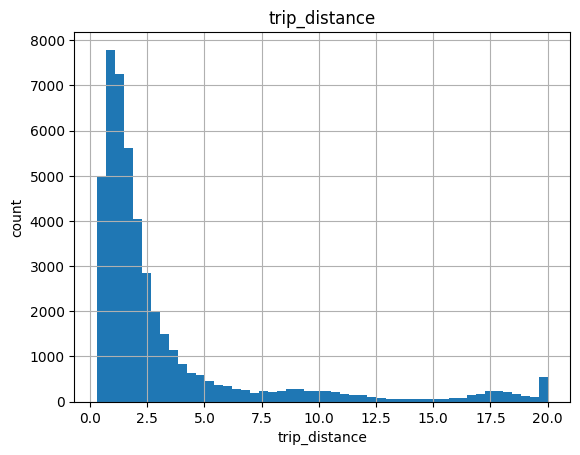

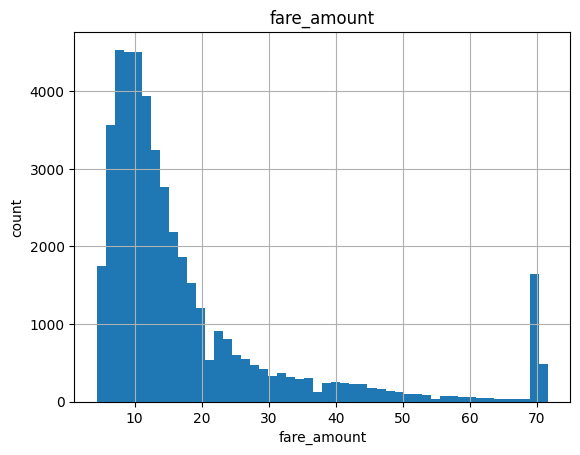

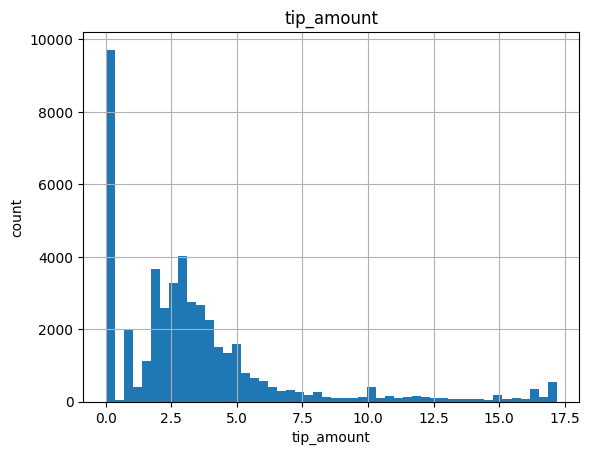

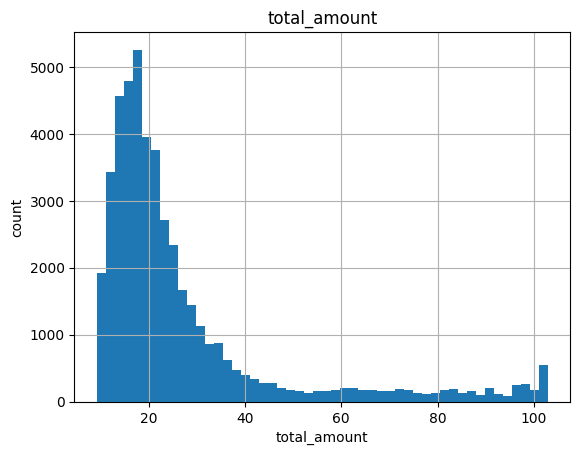

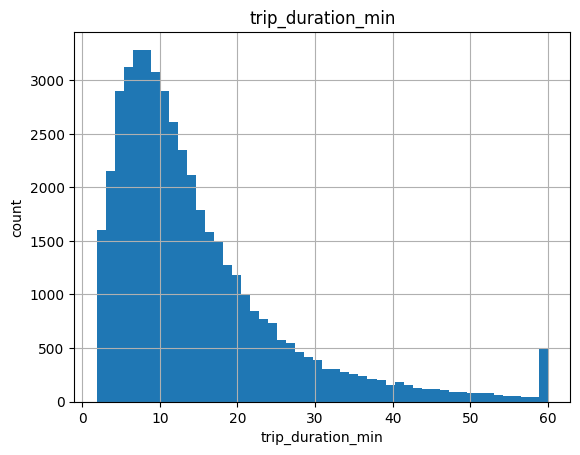

In [24]:
# ---- Visual checks ----
import matplotlib.pyplot as plt

# Histograms for a few columns (if present)
plot_cols = ["trip_distance", "fare_amount", "tip_amount", "total_amount", "trip_duration_min"]
plot_cols = [c for c in plot_cols if c in df_clean.columns]

for c in plot_cols:
    plt.figure()
    df_clean[c].clip(lower=df_clean[c].quantile(0.01), upper=df_clean[c].quantile(0.99)).hist(bins=50)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("count")
    plt.show()


In [25]:
# A few sanity checks
checks = {}
if "trip_duration_min" in df_clean.columns:
    checks["duration_min_min"] = float(df_clean["trip_duration_min"].min())
    checks["duration_min_max"] = float(df_clean["trip_duration_min"].max())
if "trip_distance" in df_clean.columns:
    checks["trip_distance_min"] = float(df_clean["trip_distance"].min())
    checks["trip_distance_max"] = float(df_clean["trip_distance"].max())
checks

{'duration_min_min': 0.03333333333333333,
 'duration_min_max': 169.73333333333332,
 'trip_distance_min': 0.01,
 'trip_distance_max': 56.22}

In [26]:
# ---- Write processed output ----
out_path = PROCESSED_DIR / "train.parquet"
df_clean.to_parquet(out_path, index=False)
out_path, out_path.exists(), out_path.stat().st_size

(PosixPath('/Users/abhijit/dev/nyc-taxi-mlops-1/data/processed/train.parquet'),
 True,
 1352953)

## Next (recommended)
- Once you're happy with the cleaning rules, copy them back into `make_dataset.py` (they should already match).
- Add a single command like `make data` / `just data` that runs the script end-to-end.
